In [12]:
# ==============================
# 1. Import Libraries
# ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings('ignore')

In [13]:
# ==============================
# 2. Load Dataset
# ==============================

df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
print(df.shape)
df.head()

(5000, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


In [21]:
# ==============================
# 3. Data Preprocessing and Cleaning
# ==============================

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'http\\S+', '', text)                  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\\s]', '', text)           # Remove special characters
    text = text.lower()                                   # Lowercase
    text = re.sub(r'\\s+', ' ', text).strip()             # Remove extra spaces
    return text

# Apply preprocessing
df['reviews.text'] = df['reviews.text'].apply(preprocess_text)

# Drop very short reviews
df = df[df['reviews.text'].str.len() > 10]

# Only keep needed columns
df = df[['reviews.text', 'reviews.rating']].dropna()


In [ ]:

# ==============================
# 4. Prepare Text and Labels
# ==============================

df = df[['reviews.text', 'reviews.rating']].dropna()

# Label sentiments based on rating
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['reviews.rating'].apply(label_sentiment)

X = df['reviews.text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# ==============================
# 5. Transformer Embedding Generation
# ==============================

# Load pretrained BERT model
embedding_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
embedding_model = AutoModel.from_pretrained('bert-base-uncased')

# Function to generate embeddings
def get_bert_embeddings(texts, tokenizer, model):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:,0,:].squeeze().numpy()
        embeddings.append(cls_embedding)
    return np.array(embeddings)

X_train_embed = get_bert_embeddings(X_train.tolist(), embedding_tokenizer, embedding_model)
X_test_embed = get_bert_embeddings(X_test.tolist(), embedding_tokenizer, embedding_model)

In [ ]:
# ==============================
# 6. Train Machine Learning Models
# ==============================

# SVM
svm_model = SVC()
svm_model.fit(X_train_embed, y_train)
y_pred_svm = svm_model.predict(X_test_embed)

# Naive Bayes (GaussianNB due to continuous embeddings)
nb_model = GaussianNB()
nb_model.fit(X_train_embed, y_train)
y_pred_nb = nb_model.predict(X_test_embed)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_embed, y_train)
y_pred_rf = rf_model.predict(X_test_embed)

In [ ]:
# ==============================
# 7. Evaluation Metrics
# ==============================

def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_true, y_pred, average='weighted'))

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='weighted'),
        "recall": recall_score(y_true, y_pred, average='weighted'),
        "f1": f1_score(y_true, y_pred, average='weighted')
    }

results = {}
results['SVM'] = evaluate_model(y_test, y_pred_svm, "SVM with BERT Embeddings")
results['Naive Bayes'] = evaluate_model(y_test, y_pred_nb, "Naive Bayes with BERT Embeddings")
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest with BERT Embeddings")



Model: SVM with BERT Embeddings
Accuracy: 0.937
Precision: 0.877969
Recall: 0.937
F1-Score: 0.9065245224574083

Model: Naive Bayes with BERT Embeddings
Accuracy: 0.765
Precision: 0.9317401892011064
Recall: 0.765
F1-Score: 0.8292990577855734

Model: Random Forest with BERT Embeddings
Accuracy: 0.953
Precision: 0.955244918699187
Recall: 0.953
F1-Score: 0.9395386706352539


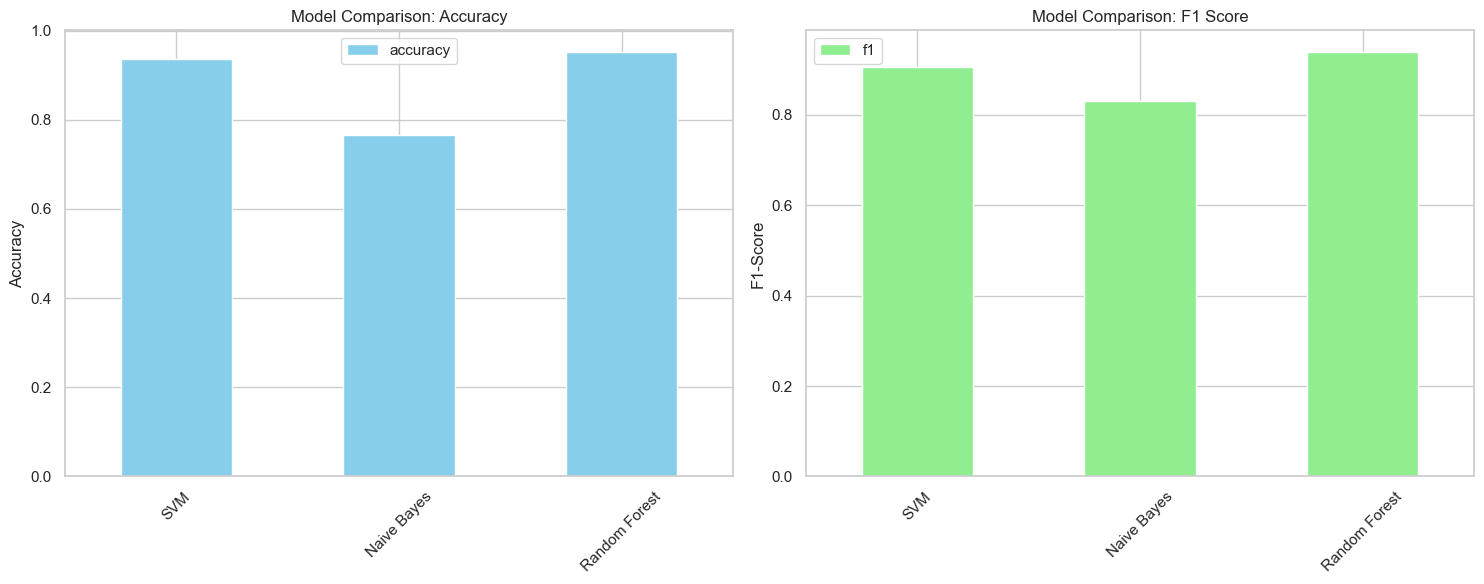

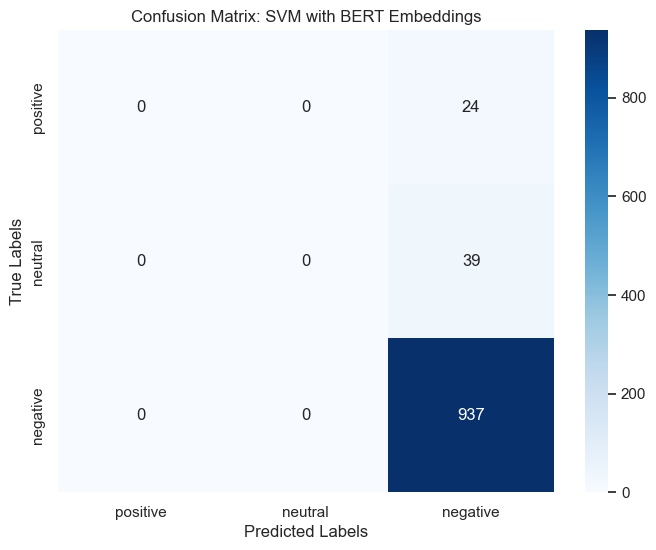

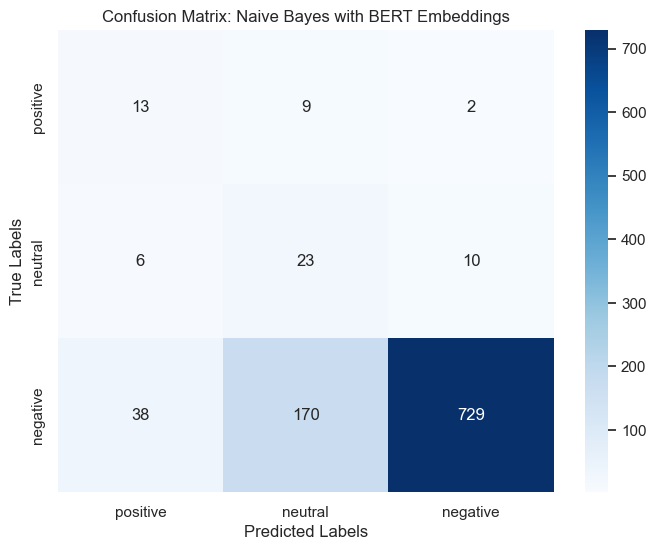

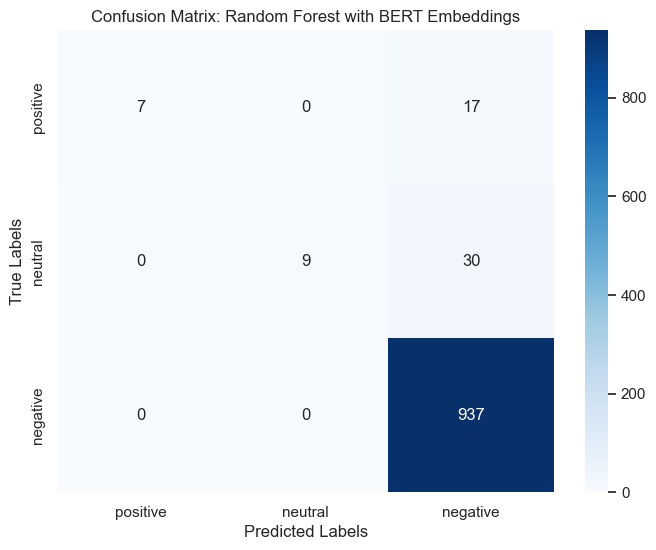

In [ ]:
# ==============================
# 8. Improved Visualization of Results
# ==============================

# Create a DataFrame for metrics from all models
metrics_df = pd.DataFrame(results).T

# Set plot style
sns.set(style="whitegrid")

# Bar plot for Accuracy and F1 Score
fig, ax = plt.subplots(1, 2, figsize=(15,6))

# Accuracy plot
metrics_df[['accuracy']].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Model Comparison: Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(metrics_df.index, rotation=45)

# F1-Score plot
metrics_df[['f1']].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Model Comparison: F1 Score')
ax[1].set_ylabel('F1-Score')
ax[1].set_xticklabels(metrics_df.index, rotation=45)

plt.tight_layout()
plt.show()

# Confusion Matrix for all models
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(y_test, y_pred_svm, "SVM with BERT Embeddings")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes with BERT Embeddings")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest with BERT Embeddings")